In [2]:
import numpy as np
import pandas as pd

# maps
import geopandas as gpd
from geopandas import GeoDataFrame
import polyline
from shapely.geometry import Point, LineString, MultiLineString

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")

#sklearn
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

## Introduction
Here I will be working with the data that we worked on in preprocessing and using it to run through some supervised and unsupervised learning methods. In the preprocessing stage, I defined both a continuous variable (speed) and a categorical variable (speed index). I will be testing both of these variables, using speed in regression models and using the speed index in categorical models.

First off, I need to load the data, then balance the classes out as a final step of preparation for the classification problem.

In [3]:
traffic_18_m = pd.read_csv('traffic_18_m.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
traffic_18_m.columns

Index(['Unnamed: 0', 'index', 'ID', 'SPEED', 'TRAVEL_TIME', 'STATUS',
       'DATA_AS_OF', 'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE',
       'ENCODED_POLY_LINE_LVLS', 'OWNER', 'TRANSCOM_ID', 'BOROUGH',
       'LINK_NAME', 'year', 'month', 'dayofweek', 'RecordedAtTime', 'hour',
       'minute', 'poly_num', 'LINK_START', 'LINK_END', 'LINK_MIDDLE',
       'speed_id', 'speed_limit', 'lion_id', 'Street', 'FeatureTyp',
       'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir', 'SeqNum', 'StreetCode',
       'StreetWidt', 'BikeLane', 'Snow_Prior', 'Number_Tra', 'Number_Tot',
       'Join_ID', 'weekend', 'morn_rush_hr', 'eve_rush_hr',
       'morning_rush_avg_spd', 'evening_rush_avg_spd', 'wknd_avg_spd',
       'overall_avg_spd', 'overall_std_speed', 'speed_index'],
      dtype='object')

In [5]:
# Some intial cleaning
traffic_18_m = traffic_18_m.drop(['Unnamed: 0', 'index'],1)
traffic_18_m.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,...,Join_ID,weekend,morn_rush_hr,eve_rush_hr,morning_rush_avg_spd,evening_rush_avg_spd,wknd_avg_spd,overall_avg_spd,overall_std_speed,speed_index
0,423,47.22,113,0,2018-12-31 23:58:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
1,423,47.84,112,0,2018-12-31 23:53:22,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
2,423,47.84,112,0,2018-12-31 23:48:24,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
3,423,46.60,115,0,2018-12-31 23:43:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
4,423,45.36,118,0,2018-12-31 23:38:24,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0


In [7]:
traffic_18_m['DATA_AS_OF'] = pd.DatetimeIndex(traffic_18_m['DATA_AS_OF'])

In [111]:
# Create a subset of the data that only traverses a month
traffic_sample = traffic_18_m.loc[(traffic_18_m['DATA_AS_OF']<'2018-06-1')&(traffic_18_m['DATA_AS_OF']>='2018-05-01')]

traffic_sample = traffic_sample.drop(columns=['LINK_POINTS','ENCODED_POLY_LINE','ENCODED_POLY_LINE_LVLS','TRANSCOM_ID','Join_ID'])

In [10]:
# Check if it worked
traffic_sample['DATA_AS_OF']

60353      2018-05-31 23:58:10
60354      2018-05-31 23:53:11
60355      2018-05-31 23:48:11
60356      2018-05-31 23:43:10
60357      2018-05-31 23:39:10
60358      2018-05-31 23:33:09
60359      2018-05-31 23:28:09
60360      2018-05-31 23:23:11
60361      2018-05-31 23:18:10
60362      2018-05-31 23:12:10
60363      2018-05-31 23:07:11
60364      2018-05-31 23:02:15
60365      2018-05-31 22:57:11
60366      2018-05-31 22:52:10
60367      2018-05-31 22:47:10
60368      2018-05-31 22:42:12
60369      2018-05-31 22:37:11
60370      2018-05-31 22:32:10
60371      2018-05-31 22:27:12
60372      2018-05-31 22:22:11
60373      2018-05-31 22:17:12
60374      2018-05-31 22:12:11
60375      2018-05-31 22:07:10
60376      2018-05-31 22:03:10
60377      2018-05-31 21:58:10
60378      2018-05-31 21:53:11
60379      2018-05-31 21:48:10
60380      2018-05-31 21:43:11
60381      2018-05-31 21:38:11
60382      2018-05-31 21:33:11
                   ...        
13311319   2018-05-01 02:28:04
13311320

In [11]:
# Check the shape
# Still having about a million rows to work with is pretty good
traffic_sample.shape

(1079068, 44)

In [12]:
traffic_sample.columns

Index(['ID', 'SPEED', 'TRAVEL_TIME', 'STATUS', 'DATA_AS_OF', 'LINK_ID',
       'OWNER', 'BOROUGH', 'LINK_NAME', 'year', 'month', 'dayofweek',
       'RecordedAtTime', 'hour', 'minute', 'poly_num', 'LINK_START',
       'LINK_END', 'LINK_MIDDLE', 'speed_id', 'speed_limit', 'lion_id',
       'Street', 'FeatureTyp', 'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir',
       'SeqNum', 'StreetCode', 'StreetWidt', 'BikeLane', 'Snow_Prior',
       'Number_Tra', 'Number_Tot', 'weekend', 'morn_rush_hr', 'eve_rush_hr',
       'morning_rush_avg_spd', 'evening_rush_avg_spd', 'wknd_avg_spd',
       'overall_avg_spd', 'overall_std_speed', 'speed_index'],
      dtype='object')

In [13]:
# check and see the distribution of the categorical variable
traffic_sample.speed_index.value_counts()

 0     280803
 5     142657
-40     99288
-5      91606
-30     75030
-10     72011
-15     61276
 10     60839
-20     54546
-25     54537
 15     33253
 25     22972
 30     15204
 20     15046
Name: speed_index, dtype: int64

In [14]:
# Pull out 50000 from each. The variables are unbalanced but this brings them almost all
# on the same level and gives us a fair amount of data to test on

traffic_s = traffic_sample.sample(frac=1, random_state=1)

traffic_ex = pd.DataFrame(columns=traffic_s.columns)

for i in traffic_s.speed_index.unique():
    label = traffic_s.loc[traffic_s['speed_index']==i][:50000]
    traffic_ex = pd.concat([traffic_ex, label])
    
traffic_ex.speed_index.value_counts()

-5     50000
-10    50000
-15    50000
-20    50000
-25    50000
-30    50000
-40    50000
 10    50000
 5     50000
 0     50000
 15    33253
 25    22972
 30    15204
 20    15046
Name: speed_index, dtype: int64

In [15]:
traffic_ex.shape

(586475, 44)

In [16]:
traffic_sample = traffic_ex

### Distribution of Data
Leveling out the speed_index seemed to help rehape the data a bit so it is more evenly distributed. Which is good. In the preprocessing stage the distribution of the speeds was heavily weighted towards 0mph, then the rest was pretty evenly distributed.

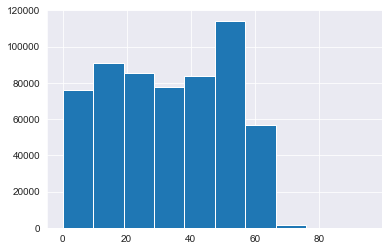

In [17]:
# Check the distribution of speeds

traffic_sample.SPEED.hist()

In [18]:
traffic_sample.speed_index.value_counts()

-5     50000
-10    50000
-15    50000
-20    50000
-25    50000
-30    50000
-40    50000
 10    50000
 5     50000
 0     50000
 15    33253
 25    22972
 30    15204
 20    15046
Name: speed_index, dtype: int64

### Convert to Numeric or to Codes

In [19]:
tonumeric = ['Number_Tot','Number_Tra','SeqNum','StreetCode','lion_id','speed_id','speed_limit']
tocategory = ['Snow_Prior','NonPed','RB_Layer','SegmentTyp','FeatureTyp','Street','BOROUGH']

# turn columns into numberic
for i in tonumeric:
    traffic_sample[i] = pd.to_numeric(traffic_sample[i])

# to a category then immediately into a coded column
for i in tocategory:
    traffic_sample[i] = traffic_sample[i].astype('category')
    traffic_sample[i+'_codes'] = traffic_sample[i].cat.codes
    
traffic_sample.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,OWNER,BOROUGH,LINK_NAME,year,...,overall_avg_spd,overall_std_speed,speed_index,Snow_Prior_codes,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes
3771382,142,37.28,200,0,2018-05-13 19:13:11,4616261,NYC_DOT_LIC,Bronx,BE S Griswold - Castle Hill Avenue,2018,...,43.220017,14.232058,-10,0,1,0,0,0,6,0
3150870,129,39.14,118,0,2018-05-21 12:48:10,4616246,NYC_DOT_LIC,Bronx,BE N STRATFORD AVENUE - CASTLE HILL AVE,2018,...,50.483482,10.406435,-10,0,1,0,0,0,6,0
10759563,445,14.29,400,0,2018-05-31 12:38:03,4456494,NYC_DOT_LIC,Manhattan,West St S Spring St - BBT Manhattan Portal out...,2018,...,8.276728,8.073302,-10,1,-1,0,4,0,29,2
2945621,106,13.67,160,0,2018-05-18 11:23:03,4616323,NYC_DOT_LIC,Manhattan,12th Ave S 57th St - 45th St,2018,...,9.596084,7.391987,-10,2,-1,0,4,0,0,2
4698323,344,37.90,117,0,2018-05-05 05:53:03,4620330,NYC_DOT_LIC,Bronx,MDE S HARLEM RIVER PARK - GWB W AMSTERDAM AVEN...,2018,...,21.705855,13.039449,-10,0,1,1,1,0,19,0


___

#### Drop Null
Before running the models, do a quick check for any null values and remove them

In [20]:
nullvals = pd.DataFrame(traffic_sample.isna().sum())
nullvals

,0
ID,0
SPEED,0
TRAVEL_TIME,0
STATUS,0
DATA_AS_OF,0
LINK_ID,0
OWNER,0
BOROUGH,0
LINK_NAME,0
year,0


In [21]:
traffic_sample = traffic_sample.drop(columns='NonPed')
traffic_sample = traffic_sample.dropna()

## Regression

Now that the data is ready to be fed into a model, the first attempt at supervised learning I will venture in to is to run the data as a regression. This will be predicting the speed of traffic given the features being inputted.

To start the whole process off, I will run the data through a Select K Best to help select only the statistically significant features. To do that, I will set it so it outputs a list of the features that return a P Value of greater than 0.05.

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_sample.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                         'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                         'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_sample['SPEED']

selector=SelectKBest(score_func=f_classif, k=30)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3  4 15 30] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,1,STATUS,14819.905066,0.000000e+00,True
1,24,overall_avg_spd,4816.336433,0.000000e+00,True
2,23,wknd_avg_spd,4472.455731,0.000000e+00,True
3,22,evening_rush_avg_spd,3961.666449,0.000000e+00,True
4,21,morning_rush_avg_spd,3562.254300,0.000000e+00,True
5,13,StreetCode,1017.946351,0.000000e+00,True
6,11,lion_id,742.190799,0.000000e+00,True
7,0,ID,694.701391,0.000000e+00,True
8,31,Street_codes,641.177499,0.000000e+00,True
9,26,Snow_Prior_codes,581.335386,0.000000e+00,True


In [23]:
X = traffic_sample[key_vals]
y = traffic_sample['SPEED']


# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Linear Regression

I will start by running a very simple linear regression model. Because of it's fairly simplistic nature, I don't expect a ton from a results perspective from it but it should give a general idea about what to expect results-wise when running more complex models on the data.

Running it returns a fairly acceptable 61% accuracy. With very little signs of overfitting — a small standard deviation among the cross validation scores — and no tuning of the model outside of running Select K Best, it seems like the data will be in a good place to be run on more complex models and return a score that would work really well for us in a production environment.

In [65]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)

ypred = reg.predict(x_test)

print('test score:')
print(reg.score(x_train, y_train))

print('\ntrain score:')
print(reg.score(x_test, y_test))

print('Coefficients:')
print(reg.coef_)

print('\nCoefficients Mean:')
print(reg.coef_.mean())

print('\nCoefficients Standard Deviation:')
print(reg.coef_.std())

print('\nIntercept:')
print(reg.intercept_)


cross_val = cross_val_score(reg, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.6167978698045254

train score:
0.6146523310862615
Coefficients:
[ 1.78939783e-01  7.91718612e-01 -4.73102671e-01  2.43382882e-01
  2.14718457e-01  1.09572848e-05 -1.51928729e-05  9.38585713e-03
 -1.48503107e-02 -2.58278011e+00  1.03541704e-01  7.38446736e-02
 -4.23742901e-02  3.93553415e-01 -9.93954248e-05  4.40294824e-01
  5.80111309e-03  1.78870559e-07 -3.15557020e-01  3.26312519e-06
 -7.47271419e+00  7.40853094e-01  1.22782898e-01  1.29613728e-01
 -1.66820699e+00 -8.74106807e+00  2.66413280e+00 -8.68127124e-01
  5.02591044e-04]

Coefficients Mean:
-0.5539936048133114

Coefficients Standard Deviation:
2.218166840184391

Intercept:
-1.6956136789890124

Cross Validation Score:
[0.61652452 0.61859412 0.61504528 0.61359977 0.61992376]

Cross Validation Mean:
0.6167374914283578

Cross Validation Standard Deviation:
0.0022958061693689065


### Random Forest

Random forest is the first of the more complex models to try on the data. From it we should expect at least a score that matches the linear regression's scores. This model I will attempt to tune as well to try to achieve a better score.

So running it for the first time returns a somewhat more disappointing score of about 65%. When I run the gridsearchCV on it, hopefully the score will improve. The other possibility, of course, is that decision tree based models may not work very well on the data. But looking at the Select K Best outcomes, and seeing that most of the highly rated features are categorical — or at least tied to the LINK — you would expect decision trees to perform fairly well.

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

rf_regr.fit(x_train, y_train)

ypred = rf_regr.predict(x_test)

print('test score:')
print(rf_regr.score(x_train, y_train))

print('\ntrain score:')
print(rf_regr.score(x_test, y_test))

print('\nFeature Importances:')
print(rf_regr.feature_importances_)



cross_val = cross_val_score(rf_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.6544526317577971

train score:
0.6565815108852273

Feature Importances:
[2.85746867e-01 6.01087021e-01 3.16531578e-02 1.01449578e-04
 2.70825143e-04 7.73239428e-03 2.92314890e-04 0.00000000e+00
 0.00000000e+00 9.16749940e-03 2.38858568e-03 0.00000000e+00
 0.00000000e+00 9.98955637e-05 2.08553192e-03 0.00000000e+00
 7.00113622e-03 2.03103971e-04 1.63681621e-04 4.83458693e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.66066673e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

Cross Validation Score:
[0.65434702 0.65714644 0.65372169 0.65157125 0.66178386]

Cross Validation Mean:
0.655714052179476

Cross Validation Standard Deviation:
0.0035183904265563303


In [132]:
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rf_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 501.9min finished


Best score for data: {'max_depth': 12, 'n_estimators': 125}


In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(max_depth=12, random_state=0, n_estimators=125)

rf_regr.fit(x_train, y_train)

ypred = rf_regr.predict(x_test)

print('test score:')
print(rf_regr.score(x_train, y_train))

print('\ntrain score:')
print(rf_regr.score(x_test, y_test))

print('\nFeature Importances:')
print(rf_regr.feature_importances_)



cross_val = cross_val_score(rf_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8220039170788623

train score:
0.8103069422625714

Feature Importances:
[1.54548804e-01 5.14669931e-01 2.48721989e-02 2.03129621e-02
 2.41526594e-02 6.50865724e-03 5.74315916e-03 1.20332612e-02
 6.08506362e-03 3.19877084e-05 1.45586521e-02 8.99061680e-04
 6.67954418e-03 2.06117846e-05 3.27139748e-03 4.38718454e-04
 4.20877692e-03 6.73877101e-03 1.30745947e-01 6.22101992e-03
 1.27940517e-02 2.81425993e-04 1.61831713e-03 2.76779134e-04
 3.00243726e-04 8.59142785e-03 5.73690909e-03 2.25498701e-02
 5.10978950e-03]

Cross Validation Score:
[0.81210275 0.81303773 0.81023395 0.81077509 0.8124293 ]

Cross Validation Mean:
0.8117157615301483

Cross Validation Standard Deviation:
0.0010475785174139023


Running the GridsearchCV really helped! It looks like before I was running the model with a far too low max-depth and a little bit too low n_estimators. It looks like what I was saying about the important features all being attached to the specific link was at least somewhat right. A nearly 82% accuracy would be more than acceptable to run in a production environment.

### K Nearest Neighbors

Next up is running the K Nearest Neighbors algorithm. From a preliminary stance, I would expect this to perform pretty well even without tuning. The data is pretty specific to time and as shown in the exploration the traffic speed at each of the links was often greatly affected by the time of day. 

As you'll see, the data does perform pretty well on the KNN from a preliminary stance, but we will see what happens after running the model through a quick gridsearchCV.

In [27]:
from sklearn.neighbors import KNeighborsRegressor

In [28]:
k_regr = KNeighborsRegressor(n_neighbors=25)

k_regr.fit(x_train, y_train)

ypred = k_regr.predict(x_test)

print('test score:')
print(k_regr.score(x_train, y_train))

print('\ntrain score:')
print(k_regr.score(x_test, y_test))


cross_val = cross_val_score(k_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8027061740513234

train score:
0.782298593801053

Cross Validation Score:
[0.7759505  0.77526116 0.77258732 0.77313044 0.77497922]

Cross Validation Mean:
0.7743817248738316

Cross Validation Standard Deviation:
0.0012943765713137243


In [29]:
from sklearn.model_selection import GridSearchCV

k_regr = KNeighborsRegressor(n_neighbors=25)

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[25,50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(k_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 58.8min finished


Best score for data: {'n_neighbors': 25}


In [71]:
from sklearn.model_selection import GridSearchCV

k_regr = KNeighborsRegressor(n_neighbors=25)

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,15,25]}

# Start the grid search again
grid_DT = GridSearchCV(k_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 15.9min finished


Best score for data: {'n_neighbors': 10}


In [72]:
k_regr = KNeighborsRegressor(n_neighbors=10)

k_regr.fit(x_train, y_train)

ypred = k_regr.predict(x_test)

print('test score:')
print(k_regr.score(x_train, y_train))

print('\ntrain score:')
print(k_regr.score(x_test, y_test))


cross_val = cross_val_score(k_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8361873573941164

train score:
0.7955570214926391

Cross Validation Score:
[0.79334018 0.79327705 0.79099601 0.79054426 0.79115603]

Cross Validation Mean:
0.791862706659303

Cross Validation Standard Deviation:
0.001197678335480948


The first score outcome was pretty impressive for KNN and you would think that running it through gridsearchCV would return a little bit more of an increase than it did, but sometimes that happened. I had to run it through twice because the first time returned the minimum supplied for K. 

I think that given more time I would explore more options for parameters to enter here. Possibly using a different weight function for K or trying a KDtree or Balltree algorithm might help improve the model even further. 

### Gradient Boosted Decision Tree

The final model I will run the regression through builds off of the random forest in being a decision tree based model. The gradient boosted decision tree tends to take a while to run so unless its an improvement or close to improvement on the random forest or KNN, I won't tune it just yet. If given more time to work with the data, I would explore tuning it via a gridsearchCV.

As you'll see, running it does return a pretty good score and I would bet even just running it again with a higher max-depth or a different number of estimators might return an even better score but this would be at the cost of performance.

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0, loss='ls')

gb_regr.fit(x_train, y_train)

ypred = gb_regr.predict(x_test)

print('test score:')
print(gb_regr.score(x_train, y_train))

print('\ntrain score:')
print(gb_regr.score(x_test, y_test))


cross_val = cross_val_score(gb_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.7575573763787654

train score:
0.7587749496228641

Cross Validation Score:
[0.75569669 0.75691412 0.75572913 0.75366305 0.7610865 ]

Cross Validation Mean:
0.7566178972693416

Cross Validation Standard Deviation:
0.002466809992119436


### Regression Conclusion

After running the data through these models, I was genuinely a little bit surprised at how well they performed, especially the KNN and Random Forest models. Luckily, I knew pretty much as soon as I ran the linear model that at least one of the more complex models would return a score that could work in a production environment.

I would ultimately recommend moving forward with the Random Forest if I were to pursue using this data as a regression problem. If it was preferred to have a model that was a little bit less of a black box, like the random forest is, than I would recommend K Nearest Neighbors.

## Classification Round 1

So this is the first venture in to attempting to predict based upon a set of classifications. As shown in the preprocessing, I created a variable for the speed in relation to the speed limit. I called it the speed index. It signifies how fast or slow traffic is moving in relation to the speed limit. If the speed index is 0, then traffic is moving at the speed limit. If it is -5, then 5mph slower. If 20, then 20mph faster. I have it set so that it moves in 5mph increments up to 30.

Now that I have introduced the classification variable, I want to let you know that **you should skip this section**. The variable as is, has too many classifiers and it was really hard to initially predict outcomes because of that. So generally the scores and the classification reports were pretty disappointing. I will note however, that if you look at the classification reports of the speed index in this state, you'll see that at least some of the classifiers perform really well, which gives hope for when the variables are simplified a bit farther

**After this section, I simplify the Speed Index variable so it is simpler to predict on. SKIP TO THAT SECTION.**

In [81]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_sample.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                         'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                         'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_sample['speed_index']

selector=SelectKBest(score_func=f_classif, k=31)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3  4 15 30] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,1,STATUS,34470.512710,0.000000e+00,True
1,10,speed_limit,33891.659068,0.000000e+00,True
2,22,evening_rush_avg_spd,27335.009641,0.000000e+00,True
3,24,overall_avg_spd,26855.849882,0.000000e+00,True
4,23,wknd_avg_spd,25028.803442,0.000000e+00,True
5,21,morning_rush_avg_spd,20679.885470,0.000000e+00,True
6,27,NonPed_codes,10616.649775,0.000000e+00,True
7,13,StreetCode,9002.521571,0.000000e+00,True
8,11,lion_id,8882.911942,0.000000e+00,True
9,31,Street_codes,6777.900247,0.000000e+00,True


In [82]:
traffic_sample['speed_index'] = traffic_sample['speed_index'].astype('category')

In [83]:
X = traffic_sample[key_vals]
y = traffic_sample['speed_index']

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Naive Bayes

In [105]:
from sklearn.metrics import classification_report

In [106]:
from datetime import datetime
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.1763008802880943

Test Percentage accuracy:
0.17604130433299914

Cross Validation:
[0.17718066 0.17600455 0.17643515 0.17595235 0.17562467]

Classification Report:

              precision    recall  f1-score   support

         -40       0.20      0.21      0.21     12287
         -30       0.17      0.36      0.23     12604
         -25       0.15      0.03      0.05     12503
         -20       0.10      0.01      0.02     12488
         -15       0.00      0.00      0.00     12442
         -10       0.34      0.17      0.22     12524
          -5       0.14      0.12      0.13     12670
           0       0.19      0.13      0.15     12496
           5       0.12      0.25      0.16     12475
          10       0.13      0.45      0.20     12602
          15       0.32      0.01      0.02      8351
          20       0.27      0.01      0.01      3744
          25       0.57      0.42      0.49      5671
          30       0.79      0.42      0.55     

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### KNN

In [79]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5172715616019788

Test Percentage accuracy:
0.49106868823276656

Cross Validation:
[0.48517811 0.48699062 0.48330113 0.48494322 0.48699498]

Classification Report:

              precision    recall  f1-score   support

         -40       0.77      0.88      0.82     12287
         -30       0.37      0.56      0.45     12604
         -25       0.39      0.38      0.38     12503
         -20       0.30      0.28      0.29     12488
         -15       0.31      0.24      0.27     12442
         -10       0.40      0.29      0.33     12524
          -5       0.45      0.36      0.40     12670
           0       0.49      0.43      0.46     12496
           5       0.55      0.60      0.57     12475
          10       0.57      0.60      0.59     12602
          15       0.63      0.70      0.66      8351
          20       0.47      0.37      0.41      3744
          25       0.60      0.82      0.69      5671
          30       0.77      0.67      0.71     

In [72]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 174.6min finished


Best score for data: {'n_neighbors': 50}


In [91]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,20,35,50]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.8min finished


Best score for data: {'n_neighbors': 10}


In [92]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5952152522643774

Test Percentage accuracy:
0.5082765535162564

Cross Validation:
[0.50337584 0.50066496 0.50101171 0.50184728 0.50165973]

Classification Report:

              precision    recall  f1-score   support

         -40       0.79      0.88      0.84     12287
         -30       0.43      0.56      0.49     12604
         -25       0.38      0.41      0.40     12503
         -20       0.31      0.32      0.31     12488
         -15       0.32      0.28      0.30     12442
         -10       0.38      0.32      0.35     12524
          -5       0.44      0.37      0.41     12670
           0       0.52      0.44      0.48     12496
           5       0.60      0.60      0.60     12475
          10       0.62      0.64      0.63     12602
          15       0.66      0.69      0.67      8351
          20       0.51      0.42      0.46      3744
          25       0.63      0.76      0.69      5671
          30       0.77      0.69      0.73      

#### Decision Tree

In [69]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6009031111111112

Test Percentage accuracy:
0.49480266666666667

Cross Validation:
[0.49605788 0.4888002  0.49050885 0.4889043  0.4921909 ]

Classification Report:

              precision    recall  f1-score   support

         -40       0.80      0.80      0.80     26809
         -30       0.39      0.52      0.45     26565
         -25       0.45      0.40      0.42     26971
         -20       0.29      0.29      0.29     26839
         -15       0.31      0.26      0.28     26639
         -10       0.34      0.28      0.31     26669
          -5       0.36      0.34      0.35     26612
           0       0.42      0.41      0.41     26720
           5       0.48      0.55      0.51     27014
          10       0.53      0.53      0.53     26873
          15       0.61      0.62      0.61     26950
          20       0.58      0.55      0.56     26657
          25       0.57      0.64      0.61     26943
          30       0.75      0.74      0.74     

#### Random Forest

In [70]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.4505697777777778

Test Percentage accuracy:
0.45056266666666667

Cross Validation:
[0.44733918 0.45014311 0.45467758 0.44807264 0.44605189]

Classification Report:
              precision    recall  f1-score   support

         -40       0.84      0.80      0.82     26809
         -30       0.28      0.54      0.37     26565
         -25       0.64      0.28      0.39     26971
         -20       0.23      0.35      0.28     26839
         -15       0.37      0.10      0.16     26639
         -10       0.41      0.17      0.24     26669
          -5       0.39      0.18      0.25     26612
           0       0.28      0.40      0.33     26720
           5       0.39      0.56      0.46     27014
          10       0.46      0.48      0.47     26873
          15       0.56      0.57      0.57     26950
          20       0.59      0.44      0.51     26657
          25       0.51      0.78      0.62     26943
          30       0.79      0.65      0.71     2

In [73]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed: 110.6min finished


Best score for data: {'max_depth': 12, 'n_estimators': 100}


In [74]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=12)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5113137777777778

Test Percentage accuracy:
0.5078373333333334

Cross Validation:
[0.50536875 0.50728431 0.50771337 0.50594452 0.50565793]

Classification Report:
              precision    recall  f1-score   support

         -40       0.82      0.85      0.83     26809
         -30       0.34      0.61      0.44     26565
         -25       0.59      0.34      0.43     26971
         -20       0.30      0.28      0.29     26839
         -15       0.39      0.21      0.27     26639
         -10       0.43      0.22      0.29     26669
          -5       0.35      0.37      0.36     26612
           0       0.39      0.47      0.42     26720
           5       0.48      0.58      0.53     27014
          10       0.54      0.52      0.53     26873
          15       0.61      0.66      0.63     26950
          20       0.63      0.52      0.57     26657
          25       0.55      0.75      0.64     26943
          30       0.78      0.72      0.75     26

#### Gradient Boosted Decision Tree

In [71]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5141937777777777

Test Percentage accuracy:
0.5132133333333333

Cross Validation:
[0.51179524 0.51163979 0.51394895 0.5114246  0.51232033]

Classification Report:
              precision    recall  f1-score   support

         -40       0.83      0.87      0.85     26809
         -30       0.39      0.56      0.46     26565
         -25       0.53      0.38      0.44     26971
         -20       0.30      0.29      0.30     26839
         -15       0.35      0.23      0.28     26639
         -10       0.38      0.26      0.31     26669
          -5       0.39      0.34      0.36     26612
           0       0.40      0.48      0.44     26720
           5       0.49      0.58      0.53     27014
          10       0.54      0.54      0.54     26873
          15       0.61      0.66      0.63     26950
          20       0.60      0.55      0.57     26657
          25       0.57      0.69      0.62     26943
          30       0.75      0.75      0.75     26

## Simplify the Classification Variable
Currently the speed index jumps at every 5mph, but because of the large amount of classes, the scores are coming out very low. As an attempt to raise accuracy, I am going to simplify what the model is predicting so that we end up with only 6 categories:

- ~ Speed limit: If traffic is moving between 10 over and 10 under then it is defined this
- 10–20mph Under: Between 10 and 20 under the speed limit
- 10–20mph Over: Between 10 and 20 Over the speed limit
- 20mph+ Under: Over 20mph under
- 20mph+ Over: Over 20mph over
- Stand Still: If traffic is moving 0mph, it is standstill traffic

In [30]:
limit = traffic_18_m['speed_limit']

traffic_18_m['speed_index'] = '~ Speed Limit'

# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-10))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-20))] = '10–20mph Under'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-20))] = '20mph+ Under'


# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+10))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+20))] = '10–20mph Ober'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+20))] = '20mph+ Over'

traffic_18_m['speed_index'].loc[traffic_18_m['SPEED']==0] = 'Stand Still'



traffic_18_m['speed_index'] = traffic_18_m['speed_index'].astype('category')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
# Very imbalanced, the majority of vehicles are moving around the speed limit

traffic_18_m['speed_index'].value_counts()

~ Speed Limit     6240474
20mph+ Under      2276659
10–20mph Under    1649383
Stand Still       1327551
10–20mph Ober     1223766
20mph+ Over        627511
Name: speed_index, dtype: int64

In [32]:
# Making sure to balance out the data before feeding it back into the models

traffic_s = traffic_18_m.sample(frac=1, random_state=1)

traffic_ex = pd.DataFrame(columns=traffic_s.columns)

for i in traffic_s.speed_index.unique():
    label = traffic_s.loc[traffic_s['speed_index']==i][:100000]
    traffic_ex = pd.concat([traffic_ex, label])
    
traffic_ex.speed_index.value_counts()

~ Speed Limit     100000
Stand Still       100000
10–20mph Under    100000
20mph+ Over       100000
10–20mph Ober     100000
20mph+ Under      100000
Name: speed_index, dtype: int64

In [33]:
traffic_ex = traffic_ex.drop(columns=['LINK_POINTS','ENCODED_POLY_LINE','ENCODED_POLY_LINE_LVLS','TRANSCOM_ID','Join_ID'])

In [34]:
tonumeric = ['Number_Tot','Number_Tra','SeqNum','StreetCode','lion_id','speed_id','speed_limit']
tocategory = ['Snow_Prior','NonPed','RB_Layer','SegmentTyp','FeatureTyp','Street','BOROUGH']

# turn columns into numberic
for i in tonumeric:
    traffic_ex[i] = pd.to_numeric(traffic_ex[i])

# to a category then immediately into a coded column
for i in tocategory:
    traffic_ex[i] = traffic_ex[i].astype('category')
    traffic_ex[i+'_codes'] = traffic_ex[i].cat.codes

In [35]:
traffic_ex = traffic_ex.drop(columns='NonPed')
traffic_ex = traffic_ex.dropna()

## Classification Round 2

Alrifht, now that I've simplified the variables, I will attempt to rerun these models and see if the outcome is improved. For this I will run the data through the exact models I did above.
- Naive Bayes: A simple model to run at the start to get a feel if the rest will work
- KNN: The only of the more complex models that doesn't revolve around the decision tree
- Decision Tree: A simple test to see if the Random Forest / Gradient Boosted would be worth it
- Random Forest: More complex but a black box, so may not be preferable
- Gradient Boosted Decision Tree: Will take a while to run but could be worth it

Like the regression, before jumping into running the models, I will run the data through a Select K Best. With the indicator for a feature going through being it having a P Value less than 0.05.

In [41]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_ex.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                     'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                     'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_ex['speed_index']

selector=SelectKBest(score_func=f_classif, k=31)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

,index,Attribute,F Score,P Value,Support
0,1,STATUS,695357.125490,0.000000e+00,True
1,10,speed_limit,104300.004767,0.000000e+00,True
2,24,overall_avg_spd,86319.739774,0.000000e+00,True
3,23,wknd_avg_spd,83260.690109,0.000000e+00,True
4,22,evening_rush_avg_spd,80704.785514,0.000000e+00,True
5,21,morning_rush_avg_spd,64981.142866,0.000000e+00,True
6,12,SeqNum,24362.309427,0.000000e+00,True
7,13,StreetCode,21855.372642,0.000000e+00,True
8,27,NonPed_codes,20675.491706,0.000000e+00,True
9,11,lion_id,18505.730573,0.000000e+00,True


In [42]:
X = traffic_ex[key_vals]
y = traffic_ex['speed_index']

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Naive Bayes

Not a good sign to start with the new outcome variables. Really disappointing score, and no real signs of life even in the classification report. Naive Bayes is a wildly simple model though, so this may ultimately be not that indicative of what is to come, **fingers crossed** though. 

In [177]:
from sklearn.metrics import classification_report

In [178]:
from datetime import datetime
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.3390088888888889

Test Percentage accuracy:
0.34170666666666666

Cross Validation:
[0.34108131 0.33695181 0.33927401 0.33854821 0.33917797]

Classification Report:

                precision    recall  f1-score   support

 10–20mph Ober       0.22      0.68      0.34     25127
10–20mph Under       0.47      0.20      0.28     25020
   20mph+ Over       0.84      0.53      0.65     25111
  20mph+ Under       0.34      0.48      0.39     24867
   Stand Still       0.21      0.00      0.00     24901
 ~ Speed Limit       0.34      0.17      0.22     24974

     micro avg       0.34      0.34      0.34    150000
     macro avg       0.40      0.34      0.31    150000
  weighted avg       0.40      0.34      0.31    150000


Duration: 0:00:18.427820


### KNN

Here I'll run the KNN and tune it a little bit as well. With how poorly the naive bayes performed, this may ultimately be the real indicator of if this data can work as a classification problem or not. Or at least if the way I framed the variables was the right way or not.

As you'll see immediately below, it works! Returning a 75% accuracy is great given the context of the naive bayes score. Hopefully doing some tuning can improve this score and get it closer to an 80%. Knn isn't necessarily known for being a model that overfits a lot and true to form, the data shows no signs of overfitting here. 

An interesting pattern that carried over from the naive bayes though is how much better the model is at predicting if traffic is moving at either 20+ Over or Under. I wonder if features like road size / number of lanes or time of day play a factor in that.

In [180]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7538288888888889

Test Percentage accuracy:
0.7414

Cross Validation:
[0.74066132 0.73932512 0.74018066 0.74124157 0.74163583]

Classification Report:

                precision    recall  f1-score   support

 10–20mph Ober       0.74      0.83      0.78     25127
10–20mph Under       0.60      0.53      0.56     25020
   20mph+ Over       0.90      0.93      0.91     25111
  20mph+ Under       0.61      0.63      0.62     24867
   Stand Still       0.90      0.98      0.94     24901
 ~ Speed Limit       0.65      0.55      0.60     24974

     micro avg       0.74      0.74      0.74    150000
     macro avg       0.73      0.74      0.74    150000
  weighted avg       0.73      0.74      0.74    150000


Duration: 0:07:21.762469


In [72]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 174.6min finished


Best score for data: {'n_neighbors': 50}


In [91]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,20,35,50]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.8min finished


Best score for data: {'n_neighbors': 10}


In [179]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7907733333333333

Test Percentage accuracy:
0.7450266666666666

Cross Validation:
[0.74265016 0.74028066 0.74245842 0.74108601 0.74374701]

Classification Report:

                precision    recall  f1-score   support

 10–20mph Ober       0.76      0.83      0.79     25127
10–20mph Under       0.57      0.58      0.58     25020
   20mph+ Over       0.91      0.93      0.92     25111
  20mph+ Under       0.62      0.62      0.62     24867
   Stand Still       0.91      0.97      0.94     24901
 ~ Speed Limit       0.67      0.54      0.60     24974

     micro avg       0.75      0.75      0.75    150000
     macro avg       0.74      0.74      0.74    150000
  weighted avg       0.74      0.75      0.74    150000


Duration: 0:06:05.832467


### Decision Tree

This will be used to get a good idea on what to expect when running the more complex models. The decision tree is very prone to overfitting so that is probably something to expect.

In [181]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8317

Test Percentage accuracy:
0.7234933333333333

Cross Validation:
[0.7195729  0.72760303 0.72330307 0.72210802 0.72359079]

Classification Report:

                precision    recall  f1-score   support

 10–20mph Ober       0.76      0.79      0.77     25127
10–20mph Under       0.55      0.56      0.56     25020
   20mph+ Over       0.90      0.91      0.91     25111
  20mph+ Under       0.60      0.62      0.61     24867
   Stand Still       0.91      0.90      0.90     24901
 ~ Speed Limit       0.62      0.55      0.58     24974

     micro avg       0.72      0.72      0.72    150000
     macro avg       0.72      0.72      0.72    150000
  weighted avg       0.72      0.72      0.72    150000


Duration: 0:00:15.600835


### Random Forest

Now that we've seen what the decision tree can do, a random forest should be able to improve upon that. Or at least in a way without overfitting too hard to the data.

An interesting thing to look out for that is present in the decision tree classification report is that it was able to predict stand still traffic at a pretty high rate. 

At the very least, that might be a factor that could play into the decision of which model to use. **Are we trying to predict traffic moving too slow/fast or traffic moving not at all?** Both are issues, of course, but depending on the goal, a decision tree or a knn could be seen as more valuable.

In [182]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7098844444444444

Test Percentage accuracy:
0.7103

Cross Validation:
[0.70805093 0.71025877 0.71178098 0.70927455 0.71193484]

Classification Report:
                precision    recall  f1-score   support

 10–20mph Ober       0.70      0.82      0.76     25127
10–20mph Under       0.62      0.38      0.47     25020
   20mph+ Over       0.92      0.87      0.90     25111
  20mph+ Under       0.54      0.66      0.59     24867
   Stand Still       0.89      0.99      0.94     24901
 ~ Speed Limit       0.57      0.54      0.56     24974

     micro avg       0.71      0.71      0.71    150000
     macro avg       0.71      0.71      0.70    150000
  weighted avg       0.71      0.71      0.70    150000


Duration: 0:01:42.946312


In [114]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 1601.4min finished


Best score for data: {'max_depth': 12, 'n_estimators': 150}


In [183]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=150, max_depth=12)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7584977777777778

Test Percentage accuracy:
0.7516066666666666

Cross Validation:
[0.75048332 0.75301386 0.75440273 0.75306392 0.75462515]

Classification Report:
                precision    recall  f1-score   support

 10–20mph Ober       0.77      0.82      0.79     25127
10–20mph Under       0.62      0.53      0.57     25020
   20mph+ Over       0.91      0.93      0.92     25111
  20mph+ Under       0.62      0.64      0.63     24867
   Stand Still       0.91      0.99      0.95     24901
 ~ Speed Limit       0.64      0.60      0.62     24974

     micro avg       0.75      0.75      0.75    150000
     macro avg       0.74      0.75      0.75    150000
  weighted avg       0.74      0.75      0.75    150000


Duration: 0:06:15.156620


Similarly to the decision tree, the random forest is able to predict stand still and very fst traffic pretty effectively. Every other variable has pretty decent performance and while the random forest didn't greatly improve the outcomes, it at least solved for the overfitting problems experienced on the decision tree.

### Gradient Boosted Decision Tree

The last model I will run with the classification is the gradient boosted decision tree. This is almost guaranteed to take a substantial amount of time to run, especially with this amount of data.

It is a very powerful model though and is more straighforward in how it works compared to the random forest, so it may ultimately be the better option. It is prone to the same overfitting issues that the decision tree is.

As you'll see below, when fitting the model (it did take quite a long time), that this is no doubt the best overall performer amongst the classification options. If it didn't take so long to run, I would try to tune it using gridsearchCV.

In [184]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(max_depth=8, n_estimators=100 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8126911111111111

Test Percentage accuracy:
0.7892466666666667

Cross Validation:
[0.78903802 0.78941345 0.7890579  0.78888654 0.79069302]

Classification Report:
                precision    recall  f1-score   support

 10–20mph Ober       0.82      0.85      0.83     25127
10–20mph Under       0.65      0.62      0.63     25020
   20mph+ Over       0.91      0.94      0.93     25111
  20mph+ Under       0.70      0.68      0.69     24867
   Stand Still       0.92      0.98      0.95     24901
 ~ Speed Limit       0.70      0.67      0.69     24974

     micro avg       0.79      0.79      0.79    150000
     macro avg       0.78      0.79      0.79    150000
  weighted avg       0.78      0.79      0.79    150000


Duration: 4:55:29.889633


### Classification Conclusions

Interestingly, the after fitting all of the models there are a couple different routes one could take, and these are of course defined by the specific goals set out in deploying a model.

If the goal was to select the best overall model, the gradient boosted decision tree would be the very obvious route to take. It was the most impressive of the bunch. Of course, it's issue is that it is pretty slow, so if performance was an issue, a random forest could work just fine.

It is when you enter the second tier of models that the decision gets tougher. To choose between the random forest and KNN, I would say it depends on what is the most important outcome to predict. Speeding/slowness vs the issue of stand-still traffic.

An intersting thing to notice throughout all of the models is that almost none of them were able to predict the 10-20mph under variable all that well. I wonder if that is because it is not quite enough of an extreme, therefore there aren't as many patterns around it's instances.

# Unsupervised

In [118]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

In [129]:
traffic_small = traffic_ex.sample(200000, random_state=1)
X_sample = traffic_small.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                               'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                               'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)

In [153]:
X_sample['LINK_ID'].describe()

count      200000
unique        130
top       4616252
freq         8751
Name: LINK_ID, dtype: int64

In [130]:
X_norm = normalize(X_sample)
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)

X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

50000 50000
50000 50000
50000 50000
50000 50000


In [131]:
# Initialize data frames
ypred_df = pd.DataFrame()
scores_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    
    # Creating a list of possible number of clusters to test in kmeans.
    for n_cluster in range(2, 10): 
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred_df['cluster ' + str(n_cluster) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        scores_df = scores_df.append({'cluster_pred':'cluster ' + str(n_cluster) + '_sample ' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)

In [132]:
# Sorting sihoilette scores
scores_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
24,cluster 2_sample 3,0.727402
0,cluster 2_sample 0,0.727020
8,cluster 2_sample 1,0.726130
16,cluster 2_sample 2,0.725916
31,cluster 9_sample 3,0.637287
15,cluster 9_sample 1,0.622769
7,cluster 9_sample 0,0.619322
9,cluster 3_sample 1,0.608615
25,cluster 3_sample 3,0.606035
17,cluster 3_sample 2,0.604242


### Mean Shift

In [123]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances

ypred_ms_df = pd.DataFrame()
score_ms_df = pd.DataFrame(columns=['cluster_pred','sil_score', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms_df['cluster ' + str(cntrs) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms_df = score_ms_df.append({'cluster_pred':'cluster ' + str(cntrs) + '_sample ' + str(counter), 
                              'sil_score':sscore, 'quantile':n}, ignore_index=True)


In [124]:
score_ms_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score,quantile
3,cluster 13_sample 1,0.702508,0.1
6,cluster 13_sample 2,0.702255,0.1
9,cluster 11_sample 3,0.672680,0.1
0,cluster 8_sample 0,0.631658,0.1
2,cluster 3_sample 0,0.608108,0.3
5,cluster 3_sample 1,0.605300,0.3
11,cluster 3_sample 3,0.599159,0.3
7,cluster 4_sample 2,0.598394,0.2
10,cluster 4_sample 3,0.597755,0.2
8,cluster 3_sample 2,0.577613,0.3


### Explore K Means

In [154]:
X_sample['LINK_ID'].describe()

count      200000
unique        130
top       4616252
freq         8751
Name: LINK_ID, dtype: int64

In [133]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=42).fit_predict(X_norm)

In [134]:
y = traffic_small[['SPEED','speed_index','ID']]

In [135]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [156]:
df_clust.shape

(200000, 1)

In [159]:
# Combining the cluster to X values
df_comb = X_sample #.join(df_clust, how='inner')
df_comb['Cluster'] = y_pred
df_comb['speed'] = y['SPEED']
df_comb['speed_index'] = y['speed_index']
df_comb['speed_index_id'] = y['ID']
df_comb.head()

,ID,STATUS,LINK_ID,year,month,dayofweek,hour,minute,poly_num,speed_id,...,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes,Cluster,speed,speed_index,speed_index_id
4625554,329,-101,4329508,2018,1,5,4,58,4,20622,...,1,0,4,0,17,2,8,0.00,Stand Still,329
1505122,331,0,4616353,2018,5,3,1,13,25,134844,...,1,1,1,0,9,3,7,15.53,30mph+ Under,331
8772859,437,0,4616203,2018,10,3,1,58,15,89550,...,-1,1,2,0,25,4,1,58.40,30mph+ Over,437
11974226,402,0,4456505,2018,6,3,21,28,15,92652,...,1,1,1,0,24,3,6,51.57,20mph Over,402
10211242,205,0,4362247,2018,10,1,14,3,61,134844,...,1,1,1,0,9,3,7,24.85,20mph Under,205


In [160]:
df_comb.shape

(200000, 37)

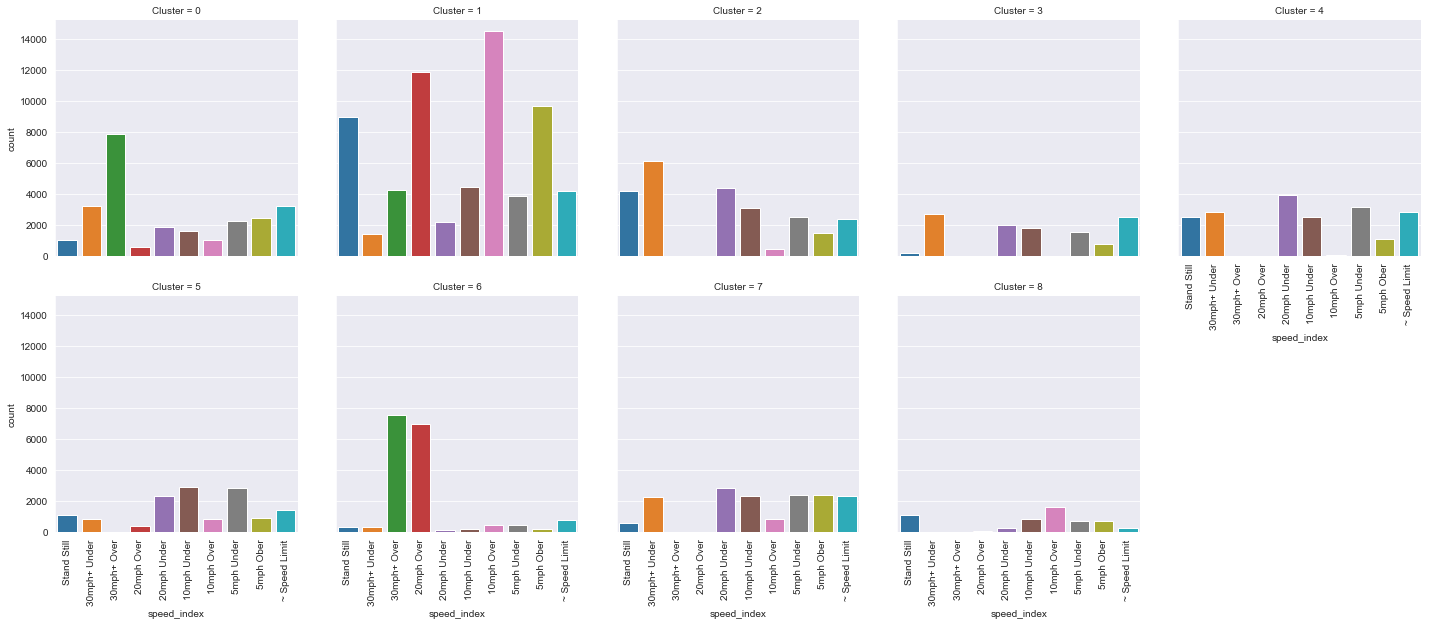

In [161]:
g = sns.factorplot(x='speed_index', col='Cluster', kind="count", data=df_comb, size=4,col_wrap=5)
g.set_xticklabels(rotation=90)

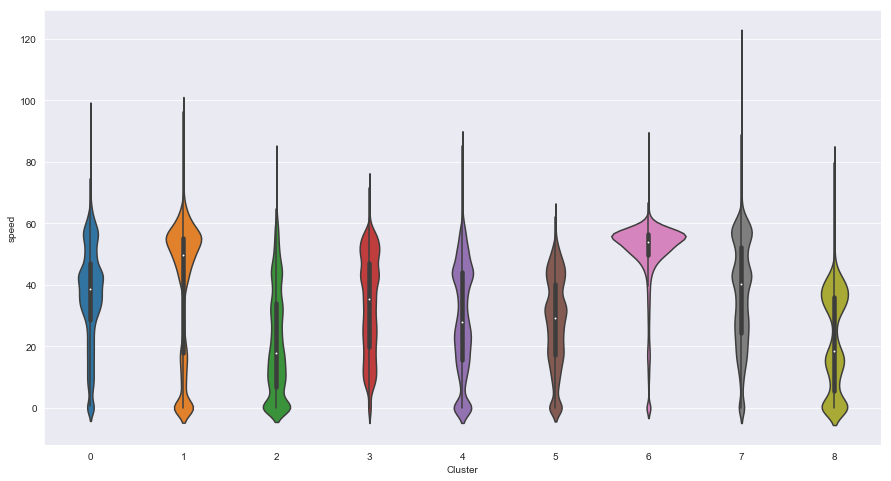

In [162]:
plt.figure(figsize=(15,8))
sns.violinplot(x='Cluster',y='speed', data=df_comb)
plt.show()

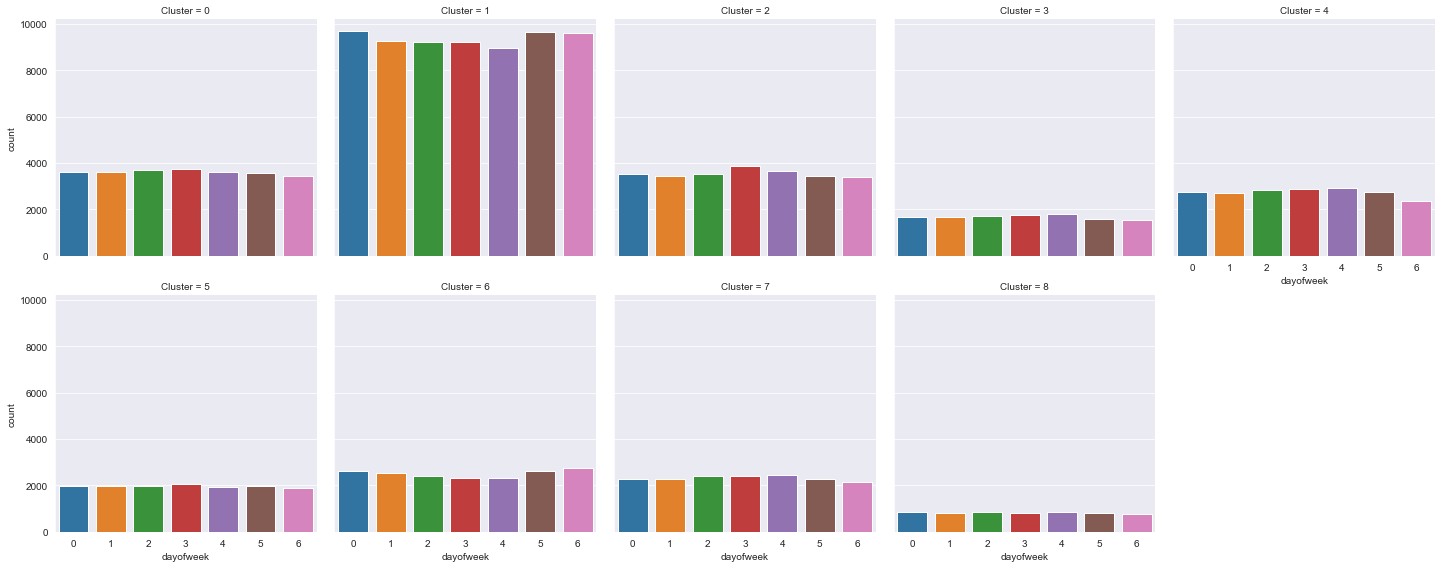

In [163]:
g = sns.factorplot(x='dayofweek', col='Cluster', kind="count", data=df_comb, size=4,col_wrap=5)

In [165]:
df_comb.groupby('Cluster')['LINK_ID'].describe()

,count,unique,top,freq
Cluster,,,,
0,25295,15,4616252,8751
1,65680,40,4616203,6180
2,24808,18,4456511,1619
3,11695,10,4616357,1748
4,19212,15,4616340,1585
5,13754,10,4456479,1593
6,17598,5,4362314,5470
7,16220,13,4616353,1527
8,5738,4,4329473,1491


In [141]:
df_comb.columns

Index(['ID', 'STATUS', 'LINK_ID', 'year', 'month', 'dayofweek', 'hour',
       'minute', 'poly_num', 'speed_id', 'speed_limit', 'lion_id', 'SeqNum',
       'StreetCode', 'StreetWidt', 'BikeLane', 'Number_Tra', 'Number_Tot',
       'weekend', 'morn_rush_hr', 'eve_rush_hr', 'morning_rush_avg_spd',
       'evening_rush_avg_spd', 'wknd_avg_spd', 'overall_avg_spd',
       'overall_std_speed', 'Snow_Prior_codes', 'NonPed_codes',
       'RB_Layer_codes', 'SegmentTyp_codes', 'FeatureTyp_codes',
       'Street_codes', 'BOROUGH_codes', 'Cluster', 'speed', 'speed_index',
       'speed_index_id'],
      dtype='object')

### Explore Mean Shift

In [126]:
bandwidth = estimate_bandwidth(X_sample, quantile=0.1, n_samples=500)
        
# Instantiating and fit_predicting model to then add to data frame
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# Calculate predicted values.
y_pred = ms.fit_predict(X_sample)

In [127]:
y = traffic_small[['SPEED','speed_index','ID']]

In [128]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [129]:
# Combining the cluster to X values
df_comb = X_sample #.join(df_clust, how='inner')
df_comb['Cluster'] = y_pred
df_comb['speed'] = y['SPEED']
df_comb['speed_index'] = y['speed_index']
df_comb['speed_index_id'] = y['ID']
df_comb.head()

,ID,STATUS,LINK_ID,year,month,dayofweek,hour,minute,poly_num,speed_id,...,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes,Cluster,speed,speed_index,speed_index_id
168307,424,0,4616300,2018,5,0,16,18,16,77399,...,1,1,1,0,26,3,5,26.71,-20,424
59292,423,0,4616299,2018,6,0,16,28,44,77399,...,1,1,1,0,26,3,3,34.79,-15,423
41088,423,0,4616299,2018,8,3,12,38,44,77399,...,1,1,1,0,26,3,2,23.61,-25,423
107279,424,0,4616300,2018,12,0,7,28,16,77399,...,1,1,1,0,26,3,3,31.06,-15,424
195779,424,0,4616300,2018,2,0,22,32,16,77399,...,1,1,1,0,26,3,1,52.19,0,424


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


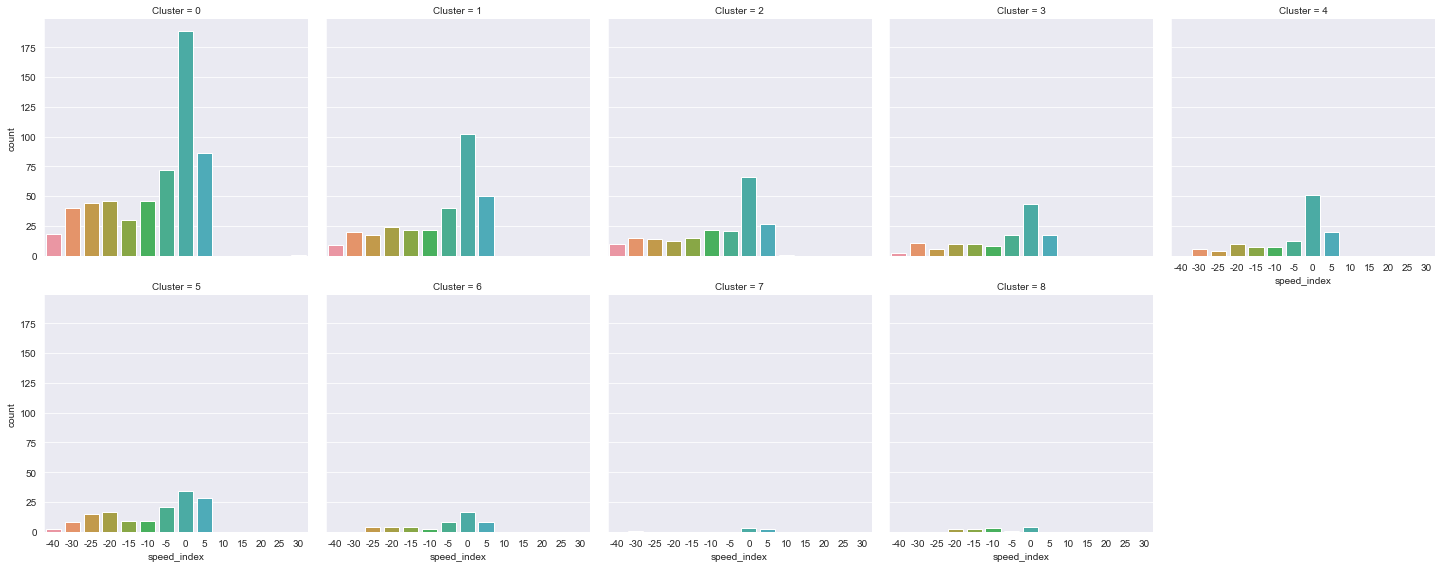

In [130]:
g = sns.factorplot(x='speed_index', col='Cluster', kind="count", data=df_comb, size=4,col_wrap=5)

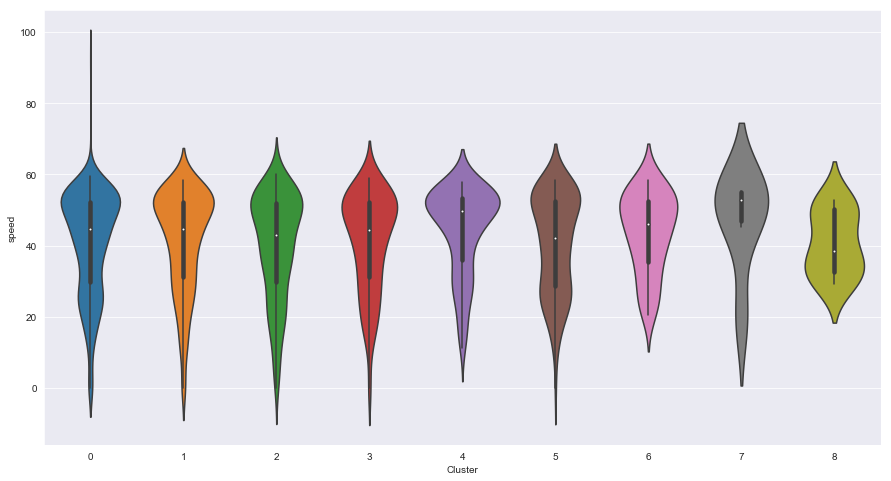

In [131]:
plt.figure(figsize=(15,8))
sns.violinplot(x='Cluster',y='speed', data=df_comb)
plt.show()

- Change the classes to be more simple
- Immediately after begin the Deep Learning because it will take some time. Use atleast 50 epochs
- Finish up and 